# mesoscope raw data conversion

This notebook shows you how to load and perform basic preprocessing on mesoscope data.

## setup plotting

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
%matplotlib inline

## import our packages

In [2]:
import mesoscope as ms
from showit import image, tile

## inspect raw data

Let's load the data included with this package for testing purposes

In [3]:
data, meta = ms.load('../data/raw')

First inspect the `data` part, it's a simple data type called `Images` that basically wraps a `numpy` array with some helpful methods

In [4]:
data

Images
mode: local
dtype: int16
shape: (23, 5152, 64)

The shape `(23,5152,64)` means that we have 23 images from different time points, each of which are shape `(5152,64)`. As we will soon see, these raw "images" are not laid out exactly as we'd like, which is why we'll need to do a conversion.

Let's check out the metadata. First, check that the shape matches the shape of our images

In [5]:
meta['shape']

(23, 5152, 64)

The raw data consisted of several rois, let's check how many there were

In [6]:
meta['nrois']

9

We can also get the center and size of each one

In [7]:
for roi in meta['rois']:
    print('roi centered at %s' % roi['center'])
    print('with size %s' % roi['npixels'])

roi centered at [-0.0049295774650499995, 6.994405055925001e-16]
with size [64, 464]
roi centered at [1.2143511555525, -6.994405055925001e-16]
with size [64, 464]
roi centered at [2.42729929575, -6.994405055925001e-16]
with size [64, 464]
roi centered at [1.823429167875, 6.994405055925001e-16]
with size [64, 464]
roi centered at [0.6053808286575, 6.994405055925001e-16]
with size [64, 464]
roi centered at [-0.615239983575, 6.994405055925001e-16]
with size [64, 464]
roi centered at [-1.8394502946750002, 6.994405055925001e-16]
with size [64, 464]
roi centered at [-2.4470176058999997, 6.994405055925001e-16]
with size [64, 464]
roi centered at [-1.2298099275, 6.994405055925001e-16]
with size [64, 464]


Remember our "images" had shape `(5152,64)`, and we had 9 rois, and each roi was shape `(64,464)`. So each "image" is actually a concatenation of multiple rois. You might be thinking that the following should hold

In [8]:
464 * 9 == 5152

False

Hm! What's going on? In the raw `tif` output, there is a black band of `122` pixels between each roi! So the correct statement is

In [9]:
464 * 9 + 122 * 8 == 5152

True

Let's look at a single image. You can use indexing to grab the first time point, and we'll convert it to a simpler `numpy` array type.

In [10]:
first = data[0].toarray()

To look at the first roi, we'll show the first 464 rows of the first image, transposed for easier viewing.

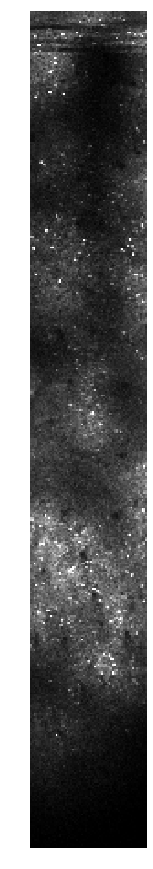

In [11]:
image(first[0:464, :], clim=(0, 4000), size=15);

Let's confirm that the subsequent 122 pixels are all black.

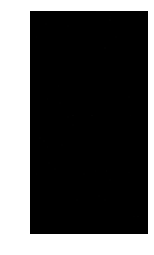

In [12]:
image(first[464:464+122, :], clim=(0, 4000), size=4);

And here's the second roi

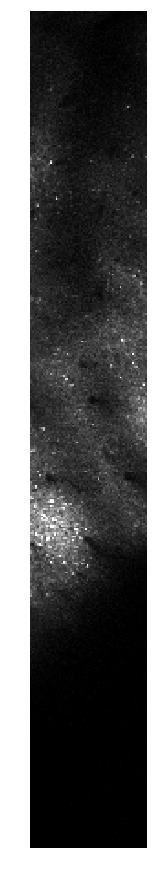

In [13]:
image(first[464+122:464*2+122, :], clim=(0, 4000), size=15);

We can do some awkward reshaping and transposing to try and look at all the rois for this one frame at once, ignoring the black bars. If the indexing here looks hairy, don't worry! In the next section we'll show a single step conversion that basically handles all of this for you.

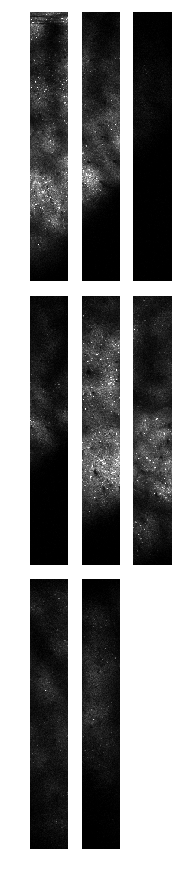

In [14]:
tile(first[0:(464+122)*8, :].reshape(8, 464 + 122, 64)[:, 0:464, :], clim=(0, 4000), size=15);

## do the conversion

Now we're going to convert the raw data into proper images in which the different rois have been merged and reshaped.

In [15]:
newdata, newmeta = ms.convert(data, meta)

First check the new metadata, it's much simpler now because we only have a single roi

In [16]:
newmeta['nrois']

1

In [17]:
for roi in newmeta['rois']:
    print('roi centered at %s' % roi['center'])
    print('with size %s' % roi['npixels'])

roi centered at [-0.0073318823644499759, 3.8857805866250004e-16]
with size [576.0, 464.0]


Look at the first image after the conversion, it should be a nice contiguous image of brain! Note the visible bands at the rois.

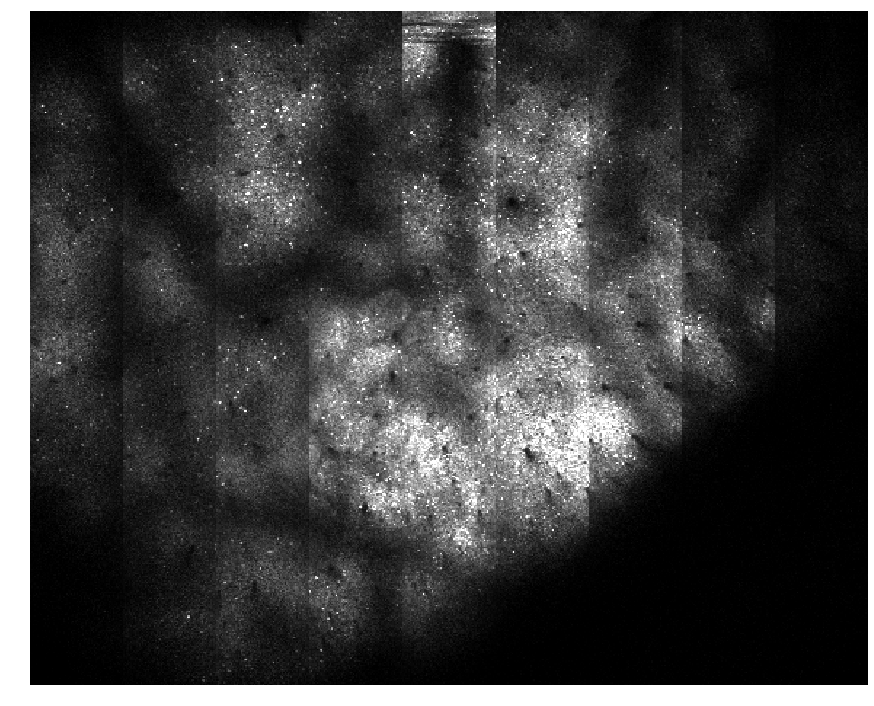

In [18]:
image(newdata[0], size=15, clim=(0,2500));

And now look at the full set of images. This is the dataset!

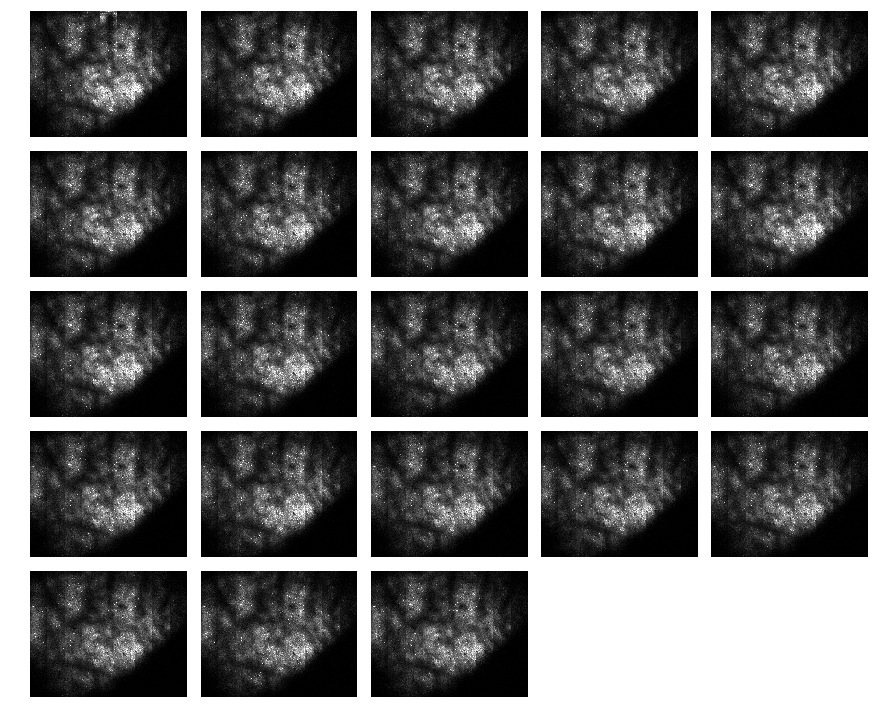

In [19]:
tile(newdata, size=15, clim=(0,2500));